In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'E:\\Datasets\\dogs_and_cats\\train'
TEST_DIR = 'E:\\Datasets\\dogs_and_cats\\test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats--{}--{}.model'.format(LR, '6conv-basic')

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog': return [0, 1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
        
    shuffle(training_data)
    np.save('training_data.npy', training_data)
    return training_data

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
# if not created already
training_data = create_train_data()

100%|███████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:23<00:00, 1072.48it/s]


In [ ]:
# else
training_data = np.load('training_data.npy')

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.config import init_graph

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

init_graph (seed=None, log_device=True, num_cores=0, gpu_memory_fraction=0.4, soft_placement=True)
model = tflearn.DNN(convnet, tensorboard_dir='log')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model Loaded!')

INFO:tensorflow:Restoring parameters from E:\Py\tensorflow-tutorials\dogs_cats_cnn\dogsvscats--0.001--6conv-basic.model
Model Loaded!


In [8]:
train = training_data[:-500]
test = training_data[-500:]

In [9]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [10]:
X.shape

(24500, 50, 50, 1)

In [ ]:
model.fit({'input': X}, {'targets': y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    batch_size=128, snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

In [ ]:
#tensorboard --logdir=foo:E:\Py\tensorflow-tutorials\dogs_cats_cnn\log

In [ ]:
model.save(MODEL_NAME)

In [11]:
import matplotlib.pyplot as plt

test_data = process_test_data()

100%|███████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:11<00:00, 1071.68it/s]


In [ ]:
test_data = np.load('test_data.npy')

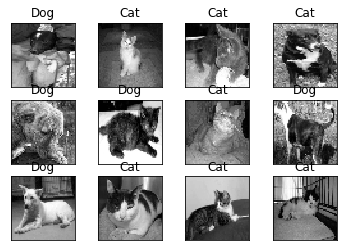

In [15]:
fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    # cat: [1, 0]
    # dog: [0, 1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label = 'Dog'
    else: str_label = 'Cat'
        
    y.imshow(orig, cmap = 'gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [20]:
with open('submission-file.csv', 'w') as f:
    f.write('id, label\n')

In [21]:
with open ('submission-file.csv', 'a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out))

100%|████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:19<00:00, 654.76it/s]
